**Stage**: Inspect Raw Data

**Objectives**:
- Verify raw stock data integrity (row count, date range, data types).
- Identify gaps in trading days, missing values, and anomalies.
- Visualize closing price and trading volume to detect trends or outliers.

---

## Data Source and Preparation
Raw stock data is sourced from a financial data provider and prepared for analysis. The dataset is dynamically selected based on the specified stock symbol, ensuring adaptability across different stocks.

In [1]:
# Parameters for automation
stock_symbol = None
fetch_id = None
config_path = "config/config.json"
auto_confirm_outliers = True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import exchange_calendars as ec
from typing import Dict, List, Optional, Callable
from spp.logging_utils import setup_logging
from spp.data_utils import parse_arguments, get_stock_symbol, get_fetch_id, load_config, load_data, format_df
from spp.plot_utils import plot_time_series
from IPython.display import Markdown, display

# Define project root directory
config = load_config(config_path="config/config.json", logger=setup_logging(logger_name="inspecting_data", log_dir="logs"))
PROJECT_ROOT = config["project_root"]

# Initialize logger
logger = setup_logging(logger_name="inspecting_data", log_dir="logs")


def verify_gaps(
    df: pd.DataFrame,
    fetch_id: str,
    exchange: str = 'XNAS',
    start_date: Optional[str] = None,
    end_date: Optional[str] = None
) -> Dict:
    """Verify gaps in stock data using the exchange calendar.
    
    Args:
        df (pd.DataFrame): Stock data DataFrame with a DatetimeIndex.
        fetch_id (str): Unique identifier for the data fetch.
        exchange (str, optional): Exchange calendar name (e.g., 'XNAS' for NASDAQ). Defaults to 'XNAS'.
        start_date (str or datetime, optional): Start date for the analysis.
        end_date (str or datetime, optional): End date for the analysis.
    
    Returns:
        Dict: A dictionary containing gap verification results.
    
    Raises:
        ValueError: If the DataFrame index is not a DatetimeIndex.
        KeyError: If the specified exchange calendar is not found.
    """
    # Validate that the DataFrame index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        logger.error("DataFrame index must be a DatetimeIndex", extra={"fetch_id": fetch_id})
        raise ValueError("DataFrame index must be a DatetimeIndex")
    
    # Ensure the DataFrame is sorted by index
    df = df.sort_index()
    
    # Convert start_date and end_date to timezone-naive timestamps
    start_date = pd.to_datetime(start_date or df.index.min()).tz_localize(None)
    end_date = pd.to_datetime(end_date or df.index.max()).tz_localize(None)

    # Get the exchange calendar
    try:
        cal = ec.get_calendar(exchange)
    except KeyError as e:
        logger.error(f"Invalid exchange calendar: {exchange}", extra={"fetch_id": fetch_id})
        raise KeyError(f"Invalid exchange calendar: {exchange}") from e

    # Get trading days
    trading_days_naive = cal.sessions_in_range(start_date, end_date)
    trading_days = trading_days_naive.tz_localize(cal.tz).tz_convert('UTC')
    
    # Convert both to date-only for comparison
    trading_days_dates = trading_days.date  # Array of datetime.date objects
    df_dates = df.index.date  # Array of datetime.date objects

    # Analyze gaps and other metrics
    result = {}
    
    # Check for weekend dates
    is_weekend = df.index.weekday >= 5
    result['weekend_dates'] = [d.isoformat() for d in df_dates[is_weekend]]
    
    # Calculate gaps
    date_series = pd.Series(df_dates, index=df.index)
    date_diff = date_series.diff().apply(lambda x: x.days if pd.notnull(x) else 0)
    gaps = date_diff[date_diff > 1].index
    result['gaps'] = [{'after': df_dates[df.index.get_loc(g) - 1].isoformat(), 'days': int(date_diff[g])} for g in gaps]
    
    # Missing trading days and non-trading index days using set operations
    trading_days_set = set(trading_days_dates)
    df_dates_set = set(df_dates)
    result['missing_trading_days'] = [d.isoformat() for d in trading_days_set - df_dates_set]
    result['non_trading_index_days'] = [d.isoformat() for d in df_dates_set - trading_days_set]
    
    # Logging
    if result['weekend_dates']:
        logger.warning(f"Weekend dates found: {len(result['weekend_dates'])} dates", extra={"fetch_id": fetch_id})
        logger.debug(f"Weekend dates details: {result['weekend_dates']}", extra={"fetch_id": fetch_id})
    else:
        logger.info("No weekend dates in index", extra={"fetch_id": fetch_id})

    if result['gaps']:
        logger.warning(f"Dates with gaps detected: {len(result['gaps'])} gaps", extra={"fetch_id": fetch_id})
        logger.debug("Gap details:", extra={"fetch_id": fetch_id})
        for gap in result['gaps']:
            logger.debug(f"Gap after {gap['after']}: {gap['days']} days", extra={"fetch_id": fetch_id})
    else:
        logger.info("No gaps in dates", extra={"fetch_id": fetch_id})

    if result['missing_trading_days']:
        logger.warning(f"Trading days missing in index: {len(result['missing_trading_days'])} days", extra={"fetch_id": fetch_id})
        logger.debug(f"Missing trading days: {result['missing_trading_days']}", extra={"fetch_id": fetch_id})
    else:
        logger.info("No trading days missing in index", extra={"fetch_id": fetch_id})

    if result['non_trading_index_days']:
        logger.warning(f"Non-trading days found in index: {len(result['non_trading_index_days'])} days", extra={"fetch_id": fetch_id})
        logger.debug(f"Non-trading days details: {result['non_trading_index_days']}", extra={"fetch_id": fetch_id})
    else:
        logger.info("All index days are trading days", extra={"fetch_id": fetch_id})

    return result


def export_gaps(
        gaps: Dict, 
        stock_symbol: str, 
        fetch_id: str
) -> None:
    """Save identified gaps to JSON files for active and historical records.
    
    Args:
        gaps (Dict): Dictionary containing gap verification results.
        stock_symbol (str): Stock symbol for the data.
        fetch_id (str): Unique identifier for the data fetch.
    
    Returns:
        None
    
    Raises:
        OSError: If there are issues creating directories or writing to files.
        TypeError: If the data cannot be serialized to JSON.
    """
    data = {
        "stock_symbol": stock_symbol,
        "fetch_id": fetch_id,
        "gaps": gaps
    }
    gaps_dir = os.path.join(PROJECT_ROOT, "data", "intermediate")
    os.makedirs(gaps_dir, exist_ok=True)
    active_file = os.path.join(gaps_dir, "gaps.json")
    history_file = os.path.join(gaps_dir, "gaps_history.jsonl")
    
    try:
        with open(active_file, 'w') as f:
            json.dump(data, f, indent=4)
        with open(history_file, 'a') as f:
            f.write(json.dumps(data) + '\n')
        logger.info(f"Gap results exported to {active_file} and appended to {history_file}", extra={"fetch_id": fetch_id})
    except OSError as e:
        logger.error(f"Failed to write gap results: {str(e)}", extra={"fetch_id": fetch_id})
        raise
    except TypeError as e:
        logger.error(f"Invalid data format for JSON serialization: {str(e)}", extra={"fetch_id": fetch_id})
        raise


def verify_data(
        df: pd.DataFrame, 
        fetch_id: str
) -> None:
    """Verify the integrity of stock data, logging key metrics and anomalies.
    
    Args:
        df (pd.DataFrame): Stock data DataFrame to verify.
        fetch_id (str): Unique identifier for the data fetch.
    """
    row_count = len(df)
    logger.info(f"Row Count: {row_count}", extra={"fetch_id": fetch_id})

    start_date, end_date = df.index.min(), df.index.max()
    date_range_days = (end_date - start_date).days + 1
    logger.info(f"Date Range: {start_date.date()} to {end_date.date()} ({date_range_days} days)", extra={"fetch_id": fetch_id})

    missing_values = df.isna().sum()
    if missing_values.any():
        logger.warning(f"Missing values found: {missing_values[missing_values > 0].to_dict()}", extra={"fetch_id": fetch_id})
    else:
        logger.info("No missing values found", extra={"fetch_id": fetch_id})

    negative_prices = df[['open', 'high', 'low', 'close']].lt(0).sum()
    if negative_prices.any():
        logger.warning(f"Negative prices found: {negative_prices[negative_prices > 0].to_dict()}", extra={"fetch_id": fetch_id})
    negative_volume = (df['volume'] < 0).sum()
    if negative_volume > 0:
        logger.warning(f"Negative volumes: {negative_volume}", extra={"fetch_id": fetch_id})

    logger.debug(f"Data Types:\n{df.dtypes.to_string()}", extra={"fetch_id": fetch_id})
    logger.debug(f"Statistics Summary:\n{df.describe().to_string()}", extra={"fetch_id": fetch_id})

    if not (missing_values.any() or negative_prices.any() or negative_volume > 0):
        logger.info("Data verification completed successfully", extra={"fetch_id": fetch_id})


def detect_anomalies(
    df: pd.DataFrame, 
    fetch_id: str, 
    detection_method: Callable[[pd.Series, bool], pd.Series]
) -> pd.DataFrame:
    """Detect anomalies in stock data using a specified detection method for each column.
    
    Args:
        df (pd.DataFrame): Stock data DataFrame with expected columns.
        fetch_id (str): Unique identifier for the data fetch.
        detection_method (Callable): A function that takes a pandas Series and a boolean 
            (indicating whether to apply log transformation) and returns a boolean Series 
            indicating anomalies.
    
    Returns:
        pd.DataFrame: DataFrame with columns 'date', 'column', 'value' for anomalies.
    
    Raises:
        TypeError: If df is not a pandas DataFrame.
        ValueError: If df is empty or missing required columns.
    """
    if not isinstance(df, pd.DataFrame):
        logger.error(f"Expected pandas DataFrame, got {type(df)}", extra={"fetch_id": fetch_id})
        raise TypeError(f"Expected pandas DataFrame, got {type(df)}")
    
    if df.empty:
        logger.error("Input DataFrame is empty", extra={"fetch_id": fetch_id})
        raise ValueError("Input DataFrame is empty")
    
    required_columns = ['open', 'high', 'low', 'close', 'volume']
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        logger.error(f"Missing required columns: {missing_cols}", extra={"fetch_id": fetch_id})
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    logger.debug(f"Processing columns: {list(df.columns)}", extra={"fetch_id": fetch_id})
    
    columns_log = ['volume']
    anomalies_list = []
    
    for col in df.columns:
        try:
            is_anomaly = detection_method(df[col], log_transform=(col in columns_log))
            if is_anomaly.any():
                for date in df.index[is_anomaly]:
                    anomalies_list.append({
                        'date': date.strftime('%Y-%m-%d'),
                        'column': col,
                        'value': df.at[date, col]
                    })
        except Exception as e:
            logger.error(f"Error processing column {col}: {str(e)}", extra={"fetch_id": fetch_id})
            raise
    
    anomalies_df = pd.DataFrame(anomalies_list, columns=['date', 'column', 'value'], 
                               index=range(1, len(anomalies_list) + 1))
    return anomalies_df


def detect_anomalies_iqr_series(
        series: pd.Series, 
        log_transform: bool = False
) -> pd.Series:
    """Detect anomalies in a series using the IQR method.
    
    Args:
        series (pd.Series): Series to analyze.
        log_transform (bool): Apply log transformation for skewed data.
    
    Returns:
        pd.Series: Boolean mask of anomalies.
    """
    if log_transform:
        series = np.log1p(series)
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)


def detect_anomalies_zscore_series(
        series: pd.Series, 
        log_transform: bool = False
) -> pd.Series:
    """Detect anomalies in a series using the z-score method.
    
    Args:
        series (pd.Series): Series to analyze.
        log_transform (bool): Apply log transformation for skewed data.
    
    Returns:
        pd.Series: Boolean mask of anomalies.
    """
    if log_transform:
        series = np.log1p(series)
    mean = series.mean()
    std = series.std()
    return (series - mean).abs() > 3 * std


def visualize_data(
        df: pd.DataFrame, 
        stock_symbol: str, 
        fetch_id: str
) -> None:
    """Visualize key stock data columns.
    
    Args:
        df (pd.DataFrame): Stock data DataFrame.
        stock_symbol (str): Stock symbol for plot titles.
        fetch_id (str): Unique identifier for the data fetch.
    """
    if df.empty or not all(col in df for col in ['close', 'volume']):
        raise ValueError("DataFrame is empty or lacks required columns: ('close', 'volume')")
    
    # Plot closing price
    plot_time_series(df, stock_symbol, fetch_id, 'close', save=True)
    # Plot trading volume
    plot_time_series(df, stock_symbol, fetch_id, 'volume', save=True)


def save_outliers(
    outliers_list: List[Dict], 
    stock_symbol: str, 
    fetch_id: str, 
    potential: bool = False
) -> None:
    """Save confirmed outliers to JSON file."""
    outlier_data = {
        "fetch_id": fetch_id,
        "stock_symbol": stock_symbol,
        "outliers": outliers_list
    }
    
    outliers_dir = os.path.join(PROJECT_ROOT, "data", "outliers")
    os.makedirs(outliers_dir, exist_ok=True)

    file_name = "potential_outliers.json" if potential else "outliers.json"
    history_file_name = "potential_outliers_history.jsonl" if potential else "outliers_history.jsonl"
    file_path = os.path.join(outliers_dir, file_name)
    history_file_path = os.path.join(outliers_dir, history_file_name)

    logger.info(f"Attempting to save outliers to: {os.path.abspath(file_path)}")
    try:
        with open(file_path, "w") as f:
            json.dump(outlier_data, f, indent=4)
        logger.info(f"Successfully wrote to {os.path.abspath(file_path)}")
        with open(history_file_path, "a") as f:
            f.write(json.dumps(outlier_data) + "\n")
        logger.info(f"Appended to {os.path.abspath(history_file_path)}")
    except (OSError, TypeError) as e:
        logger.error(f"Error saving outliers to {file_path}: {str(e)}", extra={"fetch_id": fetch_id})
        raise


def generate_summary(
    df: pd.DataFrame,
    anomalies_df: Optional[pd.DataFrame] = None
) -> None:
    """Generate and print a formatted summary of the DataFrame, including anomalies and statistics.

    Args:
        df (pd.DataFrame): Stock data DataFrame with a DatetimeIndex.
        anomalies_df (Optional[pd.DataFrame]): DataFrame containing detected anomalies, if any.

    Returns:
        None: Prints the summary directly using Markdown in Jupyter.
    """
    # Print Data Summary
    lines = [
        "#### **Data**",
        f"- **Row Count**: {len(df)}",
        f"- **Date Range**: {df.index.min().date()} to {df.index.max().date()}",
        f"- **Missing Values**: {df.isna().sum().sum()}",
        f"- **Anomalies**: {len(anomalies_df) if anomalies_df is not None else 'Not provided'}"
    ]
    display(Markdown('\n'.join(lines)))

    # Print Anomalies Details if provided and not empty
    if anomalies_df is not None and not anomalies_df.empty:
        print("\n")
        display(Markdown("#### **Anomalies**"))
        print(format_df(anomalies_df).to_string(index=True))

    # Print Summary Statistics
    stats_df = df.describe()
    if 'volume' in stats_df.columns:
        stats_df['volume'] = stats_df['volume'].round().astype(int)
    print("\n")
    display(Markdown("#### **Statistics**"))
    print(format_df(stats_df).to_string())

Logger 'inspecting_data' has been set up with log level INFO
Successfully loaded config file from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/config/config.json
Config keys: current_fetch, current_models, fetch_id, project_root, utils_dir, log_dir, plots_dir, models_dir, raw_data_dir, processed_data_dir, gaps_dir, outliers_dir, docs_data_eval_dir, docs_model_eval_dir
Logger 'inspecting_data' has been set up with log level INFO


In [3]:
def main(
    stock_symbol: str, 
    fetch_id: str, 
    config_path: str, 
    logger
) -> None:
    """Orchestrate the stock data inspection process, including loading, verifying, and analyzing data.

    This function coordinates the loading of configuration and data, verification of data integrity,
    detection of gaps and anomalies, visualization, and saving of results.

    Args:
        stock_symbol (str): Stock symbol for the data (e.g., 'TSLA').
        fetch_id (str): Unique identifier for the data fetch.
        config_path (str): Path to the configuration file.
        logger: Logger instance for logging messages.

    Returns:
        None

    Raises:
        SystemExit: If an error occurs during execution, logs the error and exits with status code 1.
    """
    try:
        config = load_config(config_path=config_path, logger=logger)
        logger.info(f"Using stock symbol: {stock_symbol} and fetch_id: {fetch_id}", extra={"fetch_id": fetch_id})
        
        # Load and process data
        df = load_data(config, stock_symbol, fetch_id, logger)
        verify_data(df, fetch_id)
        gap_results = verify_gaps(df, fetch_id)
        export_gaps(gap_results, stock_symbol, fetch_id)
        anomalies = detect_anomalies(df, fetch_id, detection_method=detect_anomalies_iqr_series)
        visualize_data(df, stock_symbol, fetch_id)
        save_outliers(anomalies.to_dict(orient='records'), stock_symbol, fetch_id)
        generate_summary(df, fetch_id, anomalies)
        
        logger.info("--------", extra={"fetch_id": fetch_id})
    
    except Exception as e:
        logger.error(f"Error in execution: {str(e)}", extra={"fetch_id": fetch_id if 'fetch_id' in locals() else "N/A"})
        raise SystemExit(1)

# Comment out automatic execution in notebook
# if __name__ == "__main__":
#     main()

In [4]:
# Load config
config = load_config(logger=logger)

# Get stock_symbol and fetch ID, using Papermill parameters if provided
stock_symbol = stock_symbol if stock_symbol is not None else get_stock_symbol(config=config)
fetch_id = fetch_id if fetch_id is not None else get_fetch_id(config=config)
config_path = config_path

logger.info(f"Using stock symbol: {stock_symbol} and fetch_id: {fetch_id}")

# main(stock_symbol, fetch_id, config_path, logger) # For papermill execution

# Load and display data
df = load_data(config, stock_symbol, fetch_id, logger=logger)
print(df.shape)
display(format_df(df.head()))

Successfully loaded config file from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/config/config.json
Config keys: current_fetch, current_models, fetch_id, project_root, utils_dir, log_dir, plots_dir, models_dir, raw_data_dir, processed_data_dir, gaps_dir, outliers_dir, docs_data_eval_dir, docs_model_eval_dir
Using stock symbol: TSLA and fetch_id: fetch_20250813_090619
Loaded raw data from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/raw/raw_tsla_fetch_20250813_090619.csv with 250 rows


(250, 5)


,open,high,low,close,volume
date,,,,,
2024-08-13,198.47,208.49,197.06,207.83,"76,247,387"
2024-08-14,207.39,208.44,198.75,201.38,"70,250,014"
2024-08-15,205.02,215.88,204.82,214.14,"89,848,530"
2024-08-16,211.15,219.80,210.80,216.12,"88,765,122"
2024-08-19,217.07,222.98,214.09,222.72,"76,435,222"


## Data Verification

This section checks the dataset for completeness and correctness, including row counts, date ranges, gaps, missing values, data types, negative values, and basic statistics.

In [5]:
gaps = verify_gaps(df, fetch_id)

No weekend dates in index
Dates with gaps detected: 57 gaps
No trading days missing in index
All index days are trading days


In [6]:
export_gaps(gaps, stock_symbol, fetch_id)

Gap results exported to /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/intermediate/gaps.json and appended to /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/intermediate/gaps_history.jsonl


In [7]:
verify_data(df, fetch_id)

Row Count: 250
Date Range: 2024-08-13 to 2025-08-12 (365 days)
No missing values found
Data verification completed successfully


## Anomaly Detection

Here, we identify potential anomalies in the data using statistical methods like the Interquartile Range (IQR), with special consideration for skewed data like volume.

In [8]:
anomalies_df = detect_anomalies(df, fetch_id, detection_method=detect_anomalies_iqr_series)
logger.info("Detected Anomalies:")
logger.info(f"Anomalies detected:\n{format_df(anomalies_df)}")

Detected Anomalies:
Anomalies detected:
         date  column           value
1  2024-11-29  volume   37,167,621.00
2  2025-06-05  volume  292,818,655.00


## Outlier Analysis

This section examines specific anomalies to confirm whether they are genuine outliers, using statistical measures and contextual information.

In [9]:
# List potential outliers
potential_outliers = anomalies_df.reset_index().to_dict(orient='records')
print("Potential outliers for manual review:")
for outlier in potential_outliers:
    print(outlier)

# Save potential outliers
save_outliers(potential_outliers, stock_symbol, fetch_id, potential=True)

Attempting to save outliers to: /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/potential_outliers.json
Successfully wrote to /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/potential_outliers.json
Appended to /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/potential_outliers_history.jsonl


Potential outliers for manual review:
{'index': 1, 'date': '2024-11-29', 'column': 'volume', 'value': 37167621.0}
{'index': 2, 'date': '2025-06-05', 'column': 'volume', 'value': 292818655.0}


In [10]:
# Optional: Manual review of outliers

# Analyze volume on 2025-06-05
print("Surrounding Data (2025-06-04 to 2025-06-06):")
display(format_df(df.loc['2025-06-04':'2025-06-06']))

# Z-score for volume on 2025-06-05
volume_on_date = df.loc['2025-06-05', 'volume']
z_score = (volume_on_date - df['volume'].mean()) / df['volume'].std()
logger.info(f"Z-score for volume on 2025-06-05: {z_score}")

# IQR validation for volume
Q1, Q3 = df['volume'].quantile(0.25), df['volume'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print(f"IQR upper bound for volume: {upper_bound}")
print(f"Is 292,818,655 an outlier? {292818655 > upper_bound}")

# Contextual information
print("Event Context: US President Donald Trump threatened to pull government contracts from Elon Musk's companies, impacting the stock.")

# Define NOT real outliers
not_real_outliers = [
    # {"date": "2025-06-05", "column": "volume", "value": "1000"}
]

Surrounding Data (2025-06-04 to 2025-06-06):


,open,high,low,close,volume
date,,,,,
2025-06-04,345.10,345.60,327.33,332.05,"98,912,075"
2025-06-05,322.49,324.55,273.21,284.70,"292,818,655"
2025-06-06,298.83,305.50,291.14,295.14,"164,747,685"


Z-score for volume on 2025-06-05: 5.178314519404959


IQR upper bound for volume: 177490430.625
Is 292,818,655 an outlier? True
Event Context: US President Donald Trump threatened to pull government contracts from Elon Musk's companies, impacting the stock.


In [11]:
# TODO: Automate outlier confirmation in script version

In [12]:
# Determine confirmed_outliers based on auto_confirm_outliers or semi-automatic filtering
logger.info(f"Processing outliers with auto_confirm_outliers={auto_confirm_outliers}", extra={"fetch_id": fetch_id})

try:
    if auto_confirm_outliers:
        logger.info("Auto-confirming all potential outliers.", extra={"fetch_id": fetch_id})
        confirmed_outliers = potential_outliers
    else:
        try:
            not_real_outliers_set = {(item['date'], item['column'], item['value']) for item in not_real_outliers}
            logger.info(f"Non-real outliers defined: {not_real_outliers_set}", extra={"fetch_id": fetch_id})
        except NameError:
            not_real_outliers_set = set()
            logger.warning("not_real_outliers not defined, treating all potential outliers as confirmed", extra={"fetch_id": fetch_id})
        confirmed_outliers = [
            outlier for outlier in potential_outliers
            if (outlier['date'], outlier['column'], outlier['value']) not in not_real_outliers_set
        ]

    # Add summary log with the number of confirmed outliers for better traceability
    logger.info(f"Number of confirmed outliers: {len(confirmed_outliers)}", extra={"fetch_id": fetch_id})

    # Save the confirmed outliers
    save_outliers(confirmed_outliers, stock_symbol, fetch_id)

    # Log each confirmed outlier for detailed traceability
    logger.info("Confirmed outliers saved:", extra={"fetch_id": fetch_id})
    for outlier in confirmed_outliers:
        logger.info(f"Date: {outlier['date']}, Column: {outlier['column']}, Value: {outlier['value']}", extra={"fetch_id": fetch_id})

except Exception as e:
    logger.error(f"Error processing outliers: {str(e)}", extra={"fetch_id": fetch_id})
    raise

Processing outliers with auto_confirm_outliers=True
Auto-confirming all potential outliers.
Number of confirmed outliers: 2
Attempting to save outliers to: /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/outliers.json
Successfully wrote to /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/outliers.json
Appended to /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/outliers/outliers_history.jsonl
Confirmed outliers saved:
Date: 2024-11-29, Column: volume, Value: 37167621.0
Date: 2025-06-05, Column: volume, Value: 292818655.0


## Visualization

Visualizations of closing price and trading volume help identify trends and anomalies visually, complementing the statistical analysis.

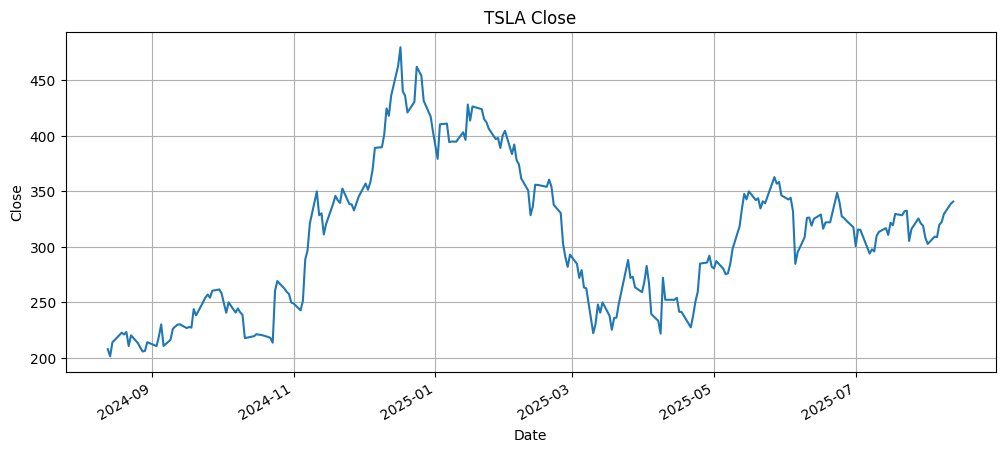

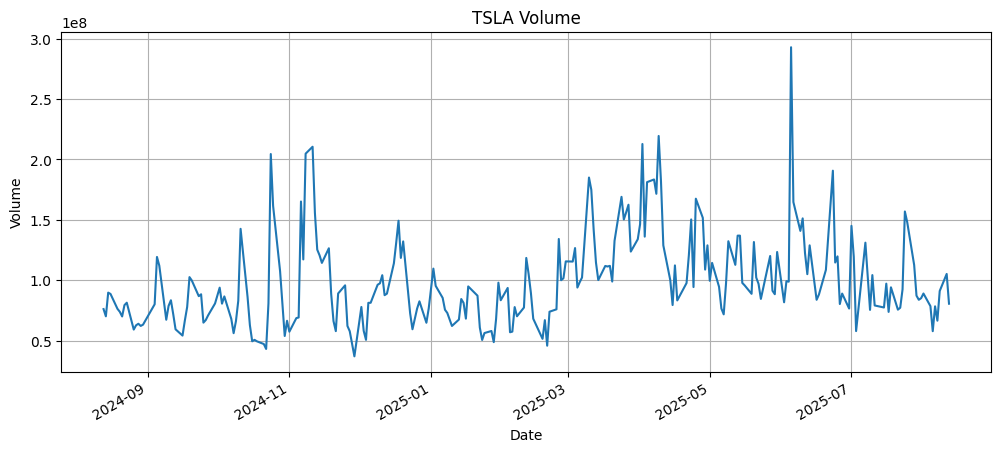

In [13]:
visualize_data(df, stock_symbol, fetch_id)

## Quantitative Summary

In [14]:
generate_summary(df, anomalies_df)

#### **Data**
- **Row Count**: 250
- **Date Range**: 2024-08-13 to 2025-08-12
- **Missing Values**: 0
- **Anomalies**: 2

#### **Anomalies**

         date  column           value
1  2024-11-29  volume   37,167,621.00
2  2025-06-05  volume  292,818,655.00




#### **Statistics**

         open    high     low   close       volume
count     250     250     250     250          250
mean   305.90  313.14  298.17  305.83   98,962,160
std     65.55   66.75   63.54   65.02   37,436,215
min    198.47  208.44  197.06  201.38   37,167,621
25%    248.34  254.32  241.40  249.98   74,440,679
50%    308.31  313.27  300.21  308.65   89,094,248
75%    345.62  354.99  336.75  344.94  115,660,580
max    475.90  488.54  457.51  479.86  292,818,655


In [15]:
print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")

## Comprehensive Analysis and Insights

### Data Coverage
- **Row Count**: 250 trading days (June 17, 2024 - June 16, 2025).  
- **Date Range**: 364 days total, with 250 trading days per U.S. market (e.g., NASDAQ) conventions.

### Trading Day Observations
Markets closed Jan. 9, 2025, for Carter’s mourning; open Oct. 14, 2024 (Columbus Day) and Nov. 11, 2024 (Veterans Day), aligning with U.S. equity calendars for data integrity.

- **Data Completeness and TypesMissing Values**: None.  
- **Data Types**: Numerical columns as float64; index as datetime64.

### Anomalies Detected
- **Volume Outlier**: June 5, 2025, with 292,818,655 shares (mean: 100,814,958; std: 39,521,561).   
    - **Validation**: Z-score 4.858 (>4.8 std), exceeds IQR upper bound; matches NASDAQ data (Yahoo Finance ~1.8% lower, likely adjusted).  
    - **Event Context**: Triggered by Trump’s threat to cancel Musk contracts, causing a 14.2% price drop ($332.05 to $284.70).  
    - **Action**: Flagged is_outlier = True, retained for modeling.

### Visualization Insights
- **Closing Price**: Rose from $181.57 (mid-2024) to $479.86 (early 2025), fell to $300–$350 by June 2025; 14.2% drop on June 5 with partial recovery.  
- **Trading Volume**: Right-skewed (median: 93.9M, mean: 100.8M); spiked to 292.8M on June 5 vs. 50–150M baseline, indicating event-driven volatility.

### Conclusion
Dataset is robust with 250 trading days, no missing values, and market calendar alignment. A notable volume outlier on June 5, 2025 (292,818,655 shares), validated by z-score (4.858) and linked to a 14.2% price drop, is retained for modeling. Visualizations reveal volatility trends and event sensitivity, with recovery patterns post-spike.

<style>
:root {
    --jp-rendermime-error-background: white;
}
</style>